# ARIMA

In [62]:
# Packages
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import numpy as np
import pickle
from pmdarima import auto_arima

## Load data

In [63]:
# Read excel in ../Data/Clean_McBroken_Daily.xlsx
df = pd.read_excel('../Data/Clean_McBroken_Daily.xlsx')
df

,Date,Broken Machines,Total Machines,Percent Broken,Revenue Losses,Outlier,Train
0,2020-10-25,354.0,6818.0,5.192138,221250.0,False,True
1,2020-10-26,373.0,6844.0,5.450029,233125.0,False,True
2,2020-10-27,427.0,7488.0,5.702457,266875.0,False,True
3,2020-10-28,391.0,8294.0,4.714251,244375.0,False,True
4,2020-10-29,374.0,7461.0,5.012733,233750.0,False,True
...,...,...,...,...,...,...,...
1577,2025-02-18,1359.0,11832.0,11.485801,849375.0,False,False
1578,2025-02-19,1190.0,11835.0,10.054922,743750.0,False,False
1579,2025-02-20,1207.0,11990.0,10.066722,754375.0,False,False
1580,2025-02-21,1110.0,11907.0,9.322247,693750.0,False,False


## ARIMA

In [64]:
# Limit to past year + test period
df = df.iloc[-(365 + 30):].reset_index(drop=True)
df

,Date,Broken Machines,Total Machines,Percent Broken,Revenue Losses,Outlier,Train
0,2024-01-25,140.0,1436.0,9.749304,87500.0,True,True
1,2024-01-26,140.0,1436.0,9.749304,87500.0,True,True
2,2024-01-27,140.0,1436.0,9.749304,87500.0,True,True
3,2024-01-28,1602.0,11097.0,14.436334,1001250.0,False,True
4,2024-01-29,140.0,1436.0,9.749304,87500.0,True,True
...,...,...,...,...,...,...,...
390,2025-02-18,1359.0,11832.0,11.485801,849375.0,False,False
391,2025-02-19,1190.0,11835.0,10.054922,743750.0,False,False
392,2025-02-20,1207.0,11990.0,10.066722,754375.0,False,False
393,2025-02-21,1110.0,11907.0,9.322247,693750.0,False,False


In [65]:
# Count missing and outlier cases
print('Missing cases:', df['Revenue Losses'].isnull().sum())
# Mark missing cases
df['Missing'] = df['Revenue Losses'].isnull()
print('Outlier cases:', df['Outlier'].sum())

Missing cases: 3
Outlier cases: 39


In [66]:
# Box-Cox Transformation on cases where Outlier is False and is not missing
orig_df = df.copy() # save original df for later plots
no_out_missing = df[(df['Outlier'] == False) & (df['Revenue Losses'].notnull())]
no_out_missing['Revenue Losses'], lam = stats.boxcox(no_out_missing['Revenue Losses'])
df.loc[no_out_missing.index, 'Revenue Losses'] = no_out_missing['Revenue Losses']
print(f'Lambda: {lam}')

# Save lam to pickle
with open('Models/ARIMA_lam.pkl', 'wb') as f:
    pickle.dump(lam, f)

Lambda: 0.9045794703642978


C:\Users\iliu\AppData\Local\Temp\ipykernel_11036\2554156724.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_out_missing['Revenue Losses'], lam = stats.boxcox(no_out_missing['Revenue Losses'])


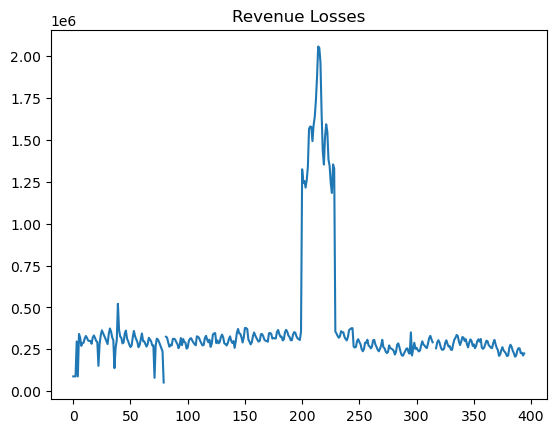

In [67]:
# Check df series
plt.plot(df['Revenue Losses'])
plt.title('Revenue Losses')
plt.show()

In [68]:
# Set missing and outlier cases to the mean of the data without them - we will use exogenous regressors to de facto remove them later
no_outlier_mean = df.query('Outlier == False').mean()['Revenue Losses']
df['Revenue Losses'] = df['Revenue Losses'].fillna(no_outlier_mean)
df['Revenue Losses'] = df['Revenue Losses'].mask(df['Outlier'], no_outlier_mean)

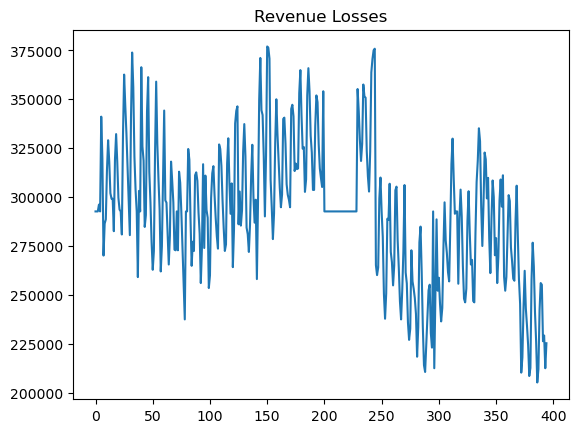

In [69]:
# Check df series
plt.plot(df['Revenue Losses'])
plt.title('Revenue Losses')
plt.show()

In [70]:
df = df[['Date', 'Revenue Losses', 'Train', 'Missing', 'Outlier']]
df

,Date,Revenue Losses,Train,Missing,Outlier
0,2024-01-25,292680.519013,True,False,True
1,2024-01-26,292680.519013,True,False,True
2,2024-01-27,292680.519013,True,False,True
3,2024-01-28,296155.112770,True,False,False
4,2024-01-29,292680.519013,True,False,True
...,...,...,...,...,...
390,2025-02-18,255207.276952,False,False,False
391,2025-02-19,226320.272961,False,False,False
392,2025-02-20,229242.942378,False,False,False
393,2025-02-21,212511.935247,False,False,False


In [71]:
# Add a column of indicators for each row to indicate whether the row is an outlier
outlier_cols = []
for i in range(len(df)):
    if df.loc[i, 'Outlier'] == 1:
        df['Outlier_' + str(df['Date'][i])] = [1 if j == i else 0 for j in range(len(df))]
        outlier_cols.append('Outlier_' + str(df['Date'][i]))
df

C:\Users\iliu\AppData\Local\Temp\ipykernel_11036\2555652712.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Outlier_' + str(df['Date'][i])] = [1 if j == i else 0 for j in range(len(df))]
C:\Users\iliu\AppData\Local\Temp\ipykernel_11036\2555652712.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Outlier_' + str(df['Date'][i])] = [1 if j == i else 0 for j in range(len(df))]


,Date,Revenue Losses,Train,Missing,Outlier,Outlier_2024-01-25 00:00:00,Outlier_2024-01-26 00:00:00,Outlier_2024-01-27 00:00:00,Outlier_2024-01-29 00:00:00,Outlier_2024-02-16 00:00:00,...,Outlier_2024-09-01 00:00:00,Outlier_2024-09-02 00:00:00,Outlier_2024-09-03 00:00:00,Outlier_2024-09-04 00:00:00,Outlier_2024-09-05 00:00:00,Outlier_2024-09-06 00:00:00,Outlier_2024-09-07 00:00:00,Outlier_2024-09-08 00:00:00,Outlier_2024-09-09 00:00:00,Outlier_2024-11-15 00:00:00
0,2024-01-25,292680.519013,True,False,True,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2024-01-26,292680.519013,True,False,True,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2024-01-27,292680.519013,True,False,True,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2024-01-28,296155.112770,True,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2024-01-29,292680.519013,True,False,True,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,2025-02-18,255207.276952,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
391,2025-02-19,226320.272961,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
392,2025-02-20,229242.942378,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
393,2025-02-21,212511.935247,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
# Add a column of indicators for each row to indicate whether the row is missing
missing_cols = []
for i in range(len(df)):
    if df.loc[i, 'Missing'] == 1:
        df['Missing_' + str(df['Date'][i])] = [1 if j == i else 0 for j in range(len(df))]
        outlier_cols.append('Missing_' + str(df['Date'][i]))
df

,Date,Revenue Losses,Train,Missing,Outlier,Outlier_2024-01-25 00:00:00,Outlier_2024-01-26 00:00:00,Outlier_2024-01-27 00:00:00,Outlier_2024-01-29 00:00:00,Outlier_2024-02-16 00:00:00,...,Outlier_2024-09-04 00:00:00,Outlier_2024-09-05 00:00:00,Outlier_2024-09-06 00:00:00,Outlier_2024-09-07 00:00:00,Outlier_2024-09-08 00:00:00,Outlier_2024-09-09 00:00:00,Outlier_2024-11-15 00:00:00,Missing_2024-04-14 00:00:00,Missing_2024-12-05 00:00:00,Missing_2024-12-06 00:00:00
0,2024-01-25,292680.519013,True,False,True,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2024-01-26,292680.519013,True,False,True,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2024-01-27,292680.519013,True,False,True,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2024-01-28,296155.112770,True,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2024-01-29,292680.519013,True,False,True,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,2025-02-18,255207.276952,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
391,2025-02-19,226320.272961,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
392,2025-02-20,229242.942378,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
393,2025-02-21,212511.935247,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
# Train/test split
train_df = df.query('Train == 1').reset_index(drop=True)
test_df = df.query('Train == 0').reset_index(drop=True)
print(len(train_df), len(test_df))

365 30


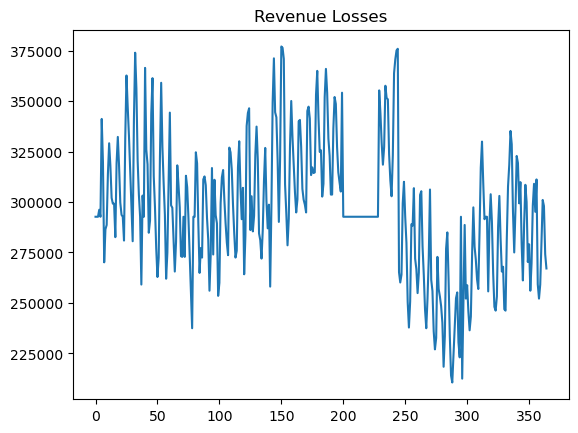

In [74]:
# Check train_df series
plt.plot(train_df['Revenue Losses'])
plt.title('Revenue Losses')
plt.show()

In [75]:
# Fit the ARIMA model using pmdarima's auto_arima
n = len(train_df)
model = auto_arima(train_df['Revenue Losses'], X=train_df[outlier_cols + missing_cols], 
                   seasonal=True, m=7, # need to ensure correct seasonality
                   suppress_warnings=True) #, with_intercept=True)
result = model.fit(train_df['Revenue Losses'], X=train_df[outlier_cols + missing_cols])

# Forecast future values with the fitted model
forecast_steps = 30

# Get the forecast for the future steps with exogenous variables
forecast_df = test_df[outlier_cols + missing_cols]
forecast_values, conf_int = model.predict(n_periods=forecast_steps, X=forecast_df, return_conf_int=True)
# Create a Pandas Series for the forecast and confidence intervals
forecast_series = pd.Series(forecast_values, index=test_df.index)
lower_series = pd.Series(conf_int[:, 0], index=test_df.index)
upper_series = pd.Series(conf_int[:, 1], index=test_df.index)

c:\Users\iliu\AppData\Local\miniforge3\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\iliu\AppData\Local\miniforge3\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\iliu\AppData\Local\miniforge3\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\iliu\AppData\Local\miniforge3\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\iliu\AppData\Local\miniforge3\envs\mcbr

In [76]:
# Model summary
print(model.summary())
print(result.params)

# Save model to disk
with open('Models/ARIMA.pkl', 'wb') as pkl:
    pickle.dump(model, pkl)

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  365
Model:             SARIMAX(3, 1, 3)x(2, 0, [1, 2], 7)   Log Likelihood               -4066.277
Date:                                Sun, 23 Feb 2025   AIC                           8240.554
Time:                                        15:24:26   BIC                           8451.000
Sample:                                             0   HQIC                          8324.197
                                                - 365                                         
Covariance Type:                                  opg                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
intercept                    -133.5183    110.08

In [77]:
# Undo box-cox transformation everywhere
forecast_series = inv_boxcox(forecast_series, lam)
forecast_values = inv_boxcox(forecast_values, lam)
lower_series = inv_boxcox(lower_series, lam)
upper_series = inv_boxcox(upper_series, lam)
df['Revenue Losses'] = inv_boxcox(df['Revenue Losses'], lam)
train_df_bc = train_df.copy() # save transformed version of train_df
train_df['Revenue Losses'] = inv_boxcox(train_df['Revenue Losses'], lam)
test_df['Revenue Losses'] = inv_boxcox(test_df['Revenue Losses'], lam)

In [78]:
# Check residuals
def plot_arima_residuals(fit, lags=10, bins=20):
    """
    Generates and displays a suite of residual plots for ARIMA models 
    fitted using pmdarima's auto_arima.

    Args:
        fit: The fitted ARIMA model object from pmdarima's auto_arima.
        lags: Number of lags to plot in the ACF.
        bins: Number of bins for the histogram.
    """

    residuals = fit.resid()  # Use fit.resid() for pmdarima
    fitted_values = fit.fittedvalues() # Use fit.fittedvalues()

    # print(residuals)
    # print(fitted_values)

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))

    # 1. Time Series Plot of Residuals
    axes[0, 0].plot(residuals)
    axes[0, 0].set_title('Residuals over Time')
    axes[0, 0].set_xlabel('Time')  # More general x-axis label
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].grid(True)

    # 2. Histogram of Residuals
    axes[0, 1].hist(residuals, bins=bins)
    axes[0, 1].set_title('Histogram of Residuals')
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Frequency')

    # 3. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot of Residuals')

    # 4. ACF Plot
    plot_acf(residuals, lags=lags, ax=axes[1, 1])
    axes[1, 1].set_title('Autocorrelation Function (ACF)')

    # 5. Residuals vs. Fitted Values
    axes[2, 0].scatter(fitted_values, residuals)
    axes[2, 0].set_title('Residuals vs. Fitted Values')
    axes[2, 0].set_xlabel('Fitted Values')
    axes[2, 0].set_ylabel('Residuals')
    axes[2, 0].grid(True)

    fig.delaxes(axes[2, 1])  # Remove the empty subplot

    plt.tight_layout()
    plt.show()

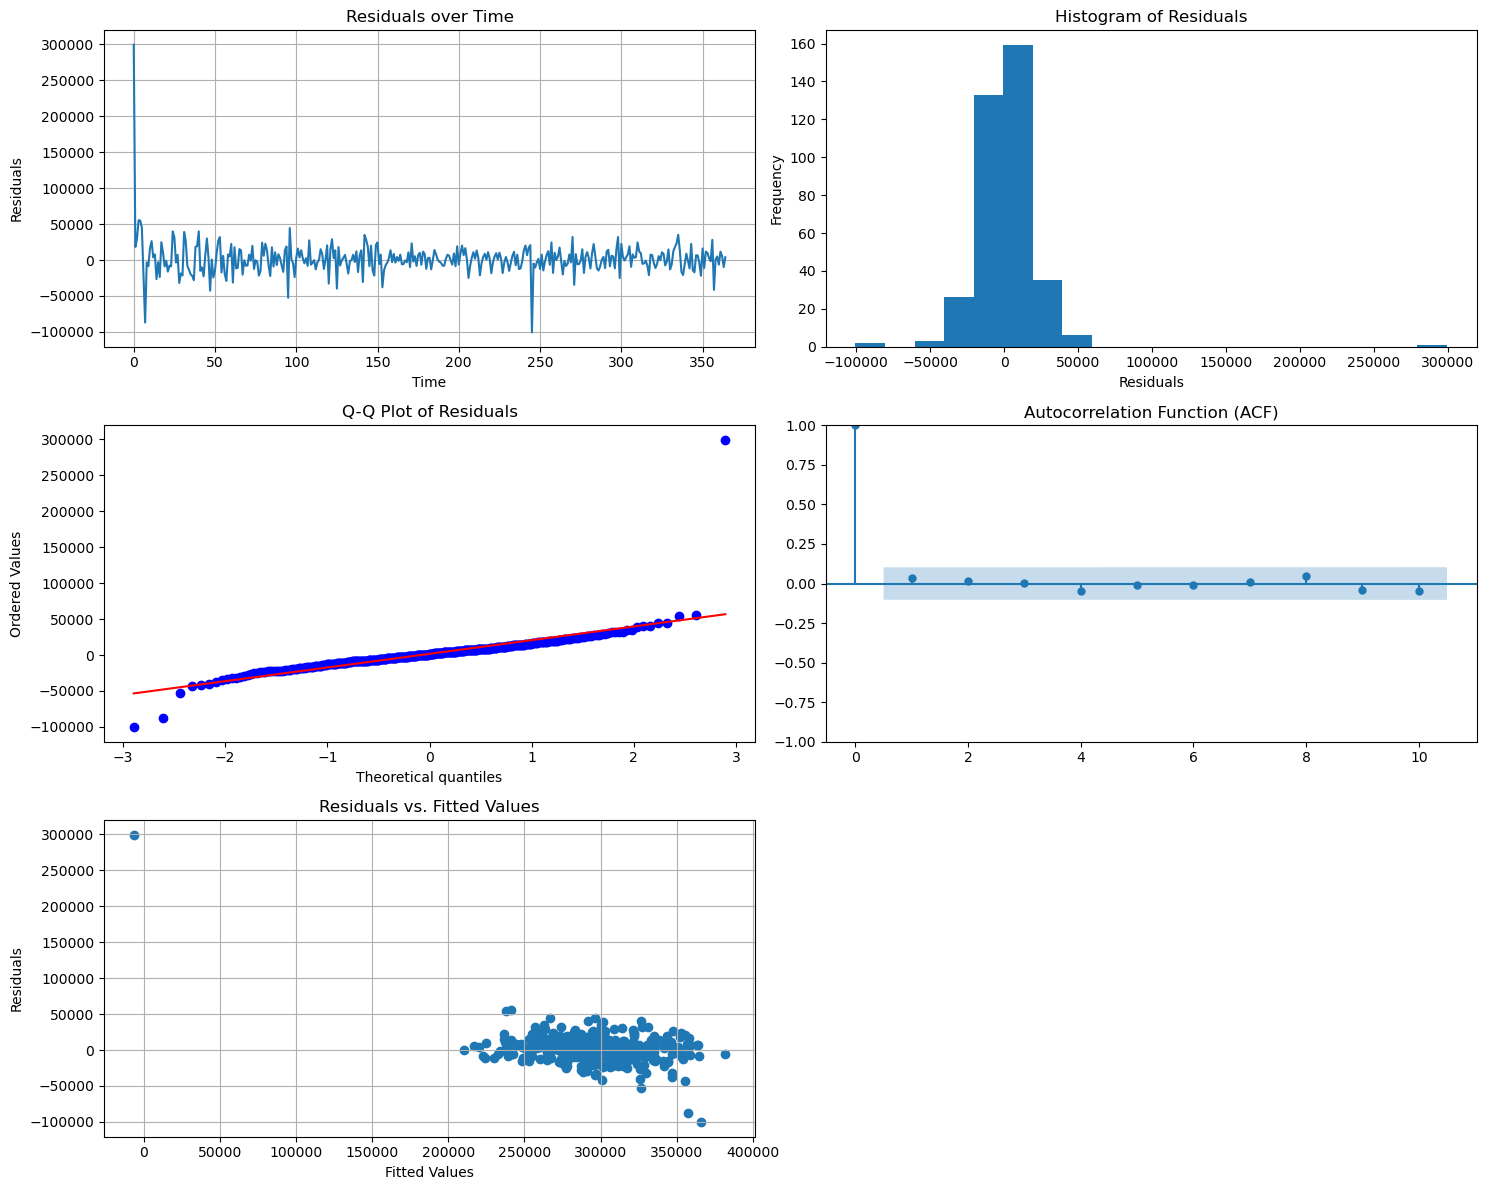

In [79]:
plot_arima_residuals(model)

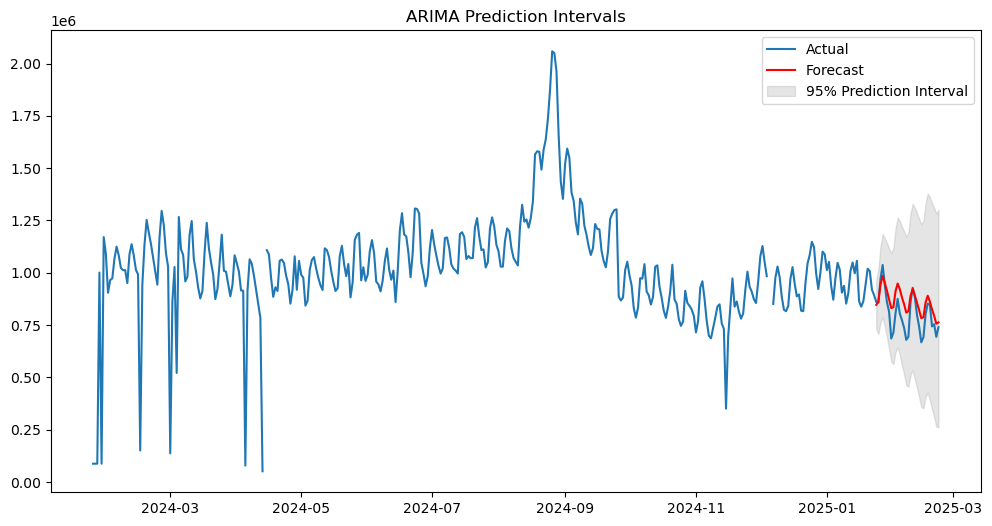

In [80]:
# Plot intervals
plt.figure(figsize=(12, 6))
plt.plot(orig_df['Date'], orig_df['Revenue Losses'], label='Actual')  # Original data
plt.plot(test_df['Date'], forecast_values, label='Forecast', color='red')  # Original forecast

plt.fill_between(test_df['Date'], lower_series, upper_series, color='gray', alpha=0.2, label=f'95% Prediction Interval')

plt.title('ARIMA Prediction Intervals')
plt.legend()
plt.show()

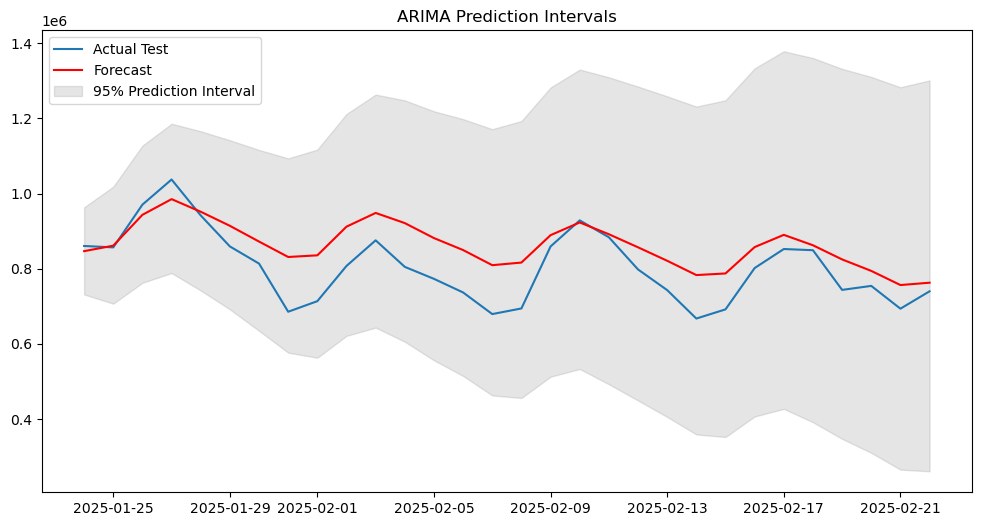

In [81]:
# Plot intervals
plt.figure(figsize=(12, 6))
plt.plot(test_df['Date'], test_df['Revenue Losses'], label='Actual Test')
plt.plot(test_df['Date'], forecast_values, label='Forecast', color='red')  # Original forecast

plt.fill_between(test_df['Date'], lower_series, upper_series, color='gray', alpha=0.2, label=f'95% Prediction Interval')

plt.title('ARIMA Prediction Intervals')
plt.legend()
plt.show()

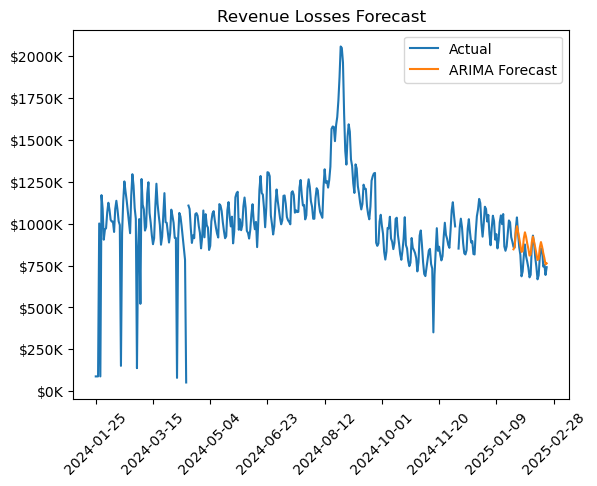

MAE: 65385.79457733801
RMSE: 78089.3656719238
MAPE: 8.669642583448828


In [82]:
plt.plot(orig_df['Revenue Losses'], label="Actual")
plt.plot(forecast_values, label="ARIMA Forecast")
# Title of Revenue Losses Forecast
plt.title('Revenue Losses Forecast')
# Format y axis as thousands of dollars
plt.gca().yaxis.set_major_formatter((lambda x, _: f'${int(x/1000)}K'))
# Format x axis as dates - add x number of days to first date in data, format as date
plt.gca().xaxis.set_major_formatter((lambda x, _: (df['Date'][0] + pd.DateOffset(days=int(x))).strftime('%Y-%m-%d')))
# Rotate x axis labels
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Check MAE, RMSE on test set
mae = mean_absolute_error(test_df['Revenue Losses'], forecast_values)
rmse = root_mean_squared_error(test_df['Revenue Losses'], forecast_values)
print('MAE:', mae)
print('RMSE:', rmse)
# Also compute MAPE for reporting
mape = np.mean(np.abs((test_df['Revenue Losses'] - list(forecast_values)) / test_df['Revenue Losses'])) * 100
print('MAPE:', mape)

In [83]:
# 7-day seasonal naive forecast for comparison
last_7 = list(train_df['Revenue Losses'][-7:])
seasonal_naive_forecast = [last_7[i % 7] for i in range(len(test_df))]
# Set index of dates to be that of test_df
seasonal_naive_forecast_df = pd.DataFrame(seasonal_naive_forecast, index=test_df.index, columns=['Revenue Losses'])

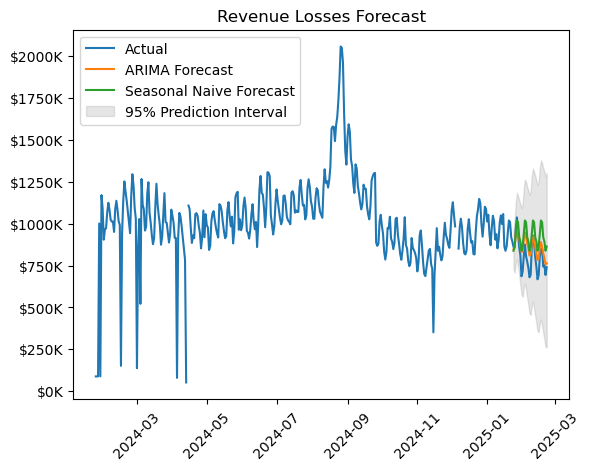

Seasonal Naive MAE: 121687.4999999998
Seasonal Naive RMSE: 132294.898254493
Seasonal Naive MAPE: 15.838210192694516


In [84]:
# PLot with seasonal naive forecast
orig_df = orig_df.sort_values('Date')
plt.plot(orig_df['Date'], orig_df['Revenue Losses'], label="Actual")
plt.plot(test_df['Date'], forecast_values, label="ARIMA Forecast")
# Seasonal naive forecast
plt.plot(test_df['Date'], seasonal_naive_forecast_df['Revenue Losses'], label="Seasonal Naive Forecast")
# Add prediction intervals
plt.fill_between(test_df['Date'], lower_series, upper_series, color='gray', alpha=0.2, label='95% Prediction Interval')
# Title of Revenue Losses Forecast
plt.title('Revenue Losses Forecast')
# Format y axis as thousands of dollars
plt.gca().yaxis.set_major_formatter((lambda x, _: f'${int(x/1000)}K'))
# Rotate x axis labels
plt.xticks(rotation=45)
plt.legend()
plt.show()

# MAE, RMSE, MAPE for seasonal naive forecast
mae = mean_absolute_error(test_df['Revenue Losses'], seasonal_naive_forecast)
rmse = root_mean_squared_error(test_df['Revenue Losses'], seasonal_naive_forecast)
print('Seasonal Naive MAE:', mae)
print('Seasonal Naive RMSE:', rmse)
mape = np.mean(np.abs((test_df['Revenue Losses'] - seasonal_naive_forecast) / test_df['Revenue Losses'])) * 100
print('Seasonal Naive MAPE:', mape)

Not really a great fit.